# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [63]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle
import math

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### For calibrating images

---------->   Run camera_calibrate.ipynb,  
---------->   It saves the coefficients and mtx array in cam_cal_data.p pickle file

### Undistort Images

In [64]:
# Load the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera() in the file calibrate.ipynb
dist_pickle = pickle.load( open( "cam_cal_data.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
call_img_size = dist_pickle["img_size"]

def undistort_img(img):
    assert (img.shape == call_img_size),'image size of {} is not compatible with callibration camera images'.format(img.shape)
    return cv2.undistort(img, mtx, dist, None, mtx)

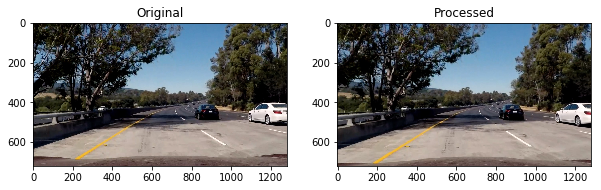

In [65]:
# TEST

test_img = mpimg.imread('test_images/test5.jpg')
test_undistorted = undistort_img(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Original')
ax1.imshow(test_img)
ax2.set_title('Processed')  
ax2.imshow(test_undistorted)

### Defining various Gradients  : sobel, magnitude, direction

In [66]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Combining the thresholds of gradients

In [67]:
def combined_thresh(image, ksize = 3):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, thresh=(30, 255))
    dir_binary = dir_thresh(image, sobel_kernel=15, thresh=(0.7,1.3)) 
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

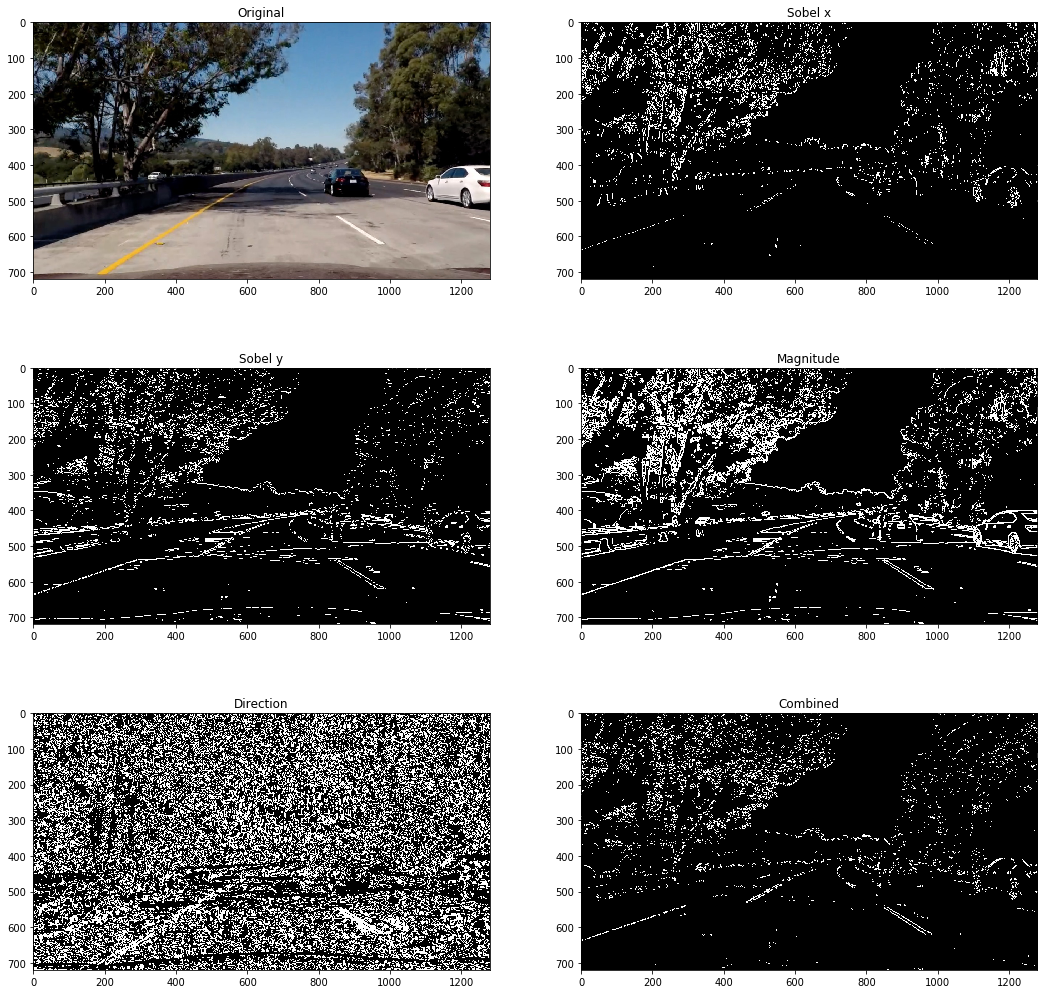

In [68]:
# TEST

sobelx = abs_sobel_thresh(test_undistorted, orient='x', sobel_kernel=3, thresh=(30, 100))
sobely = abs_sobel_thresh(test_undistorted, orient='y', sobel_kernel=3, thresh=(30, 100))
mag = mag_thresh(test_undistorted, sobel_kernel=3, thresh=(30, 255))
dire = dir_thresh(test_undistorted, sobel_kernel=15, thresh=(0.7,1.3))
comb = combined_thresh(test_undistorted)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(18,18))
ax1.set_title('Original')
ax1.imshow(test_undistorted)
ax2.set_title('Sobel x')  
ax2.imshow(sobelx, cmap = 'gray')
ax3.set_title('Sobel y')  
ax3.imshow(sobely, cmap = 'gray')
ax4.set_title('Magnitude')  
ax4.imshow(mag, cmap = 'gray')
ax5.set_title('Direction')  
ax5.imshow(dire, cmap = 'gray')
ax6.set_title('Combined')  
ax6.imshow(comb, cmap = 'gray')

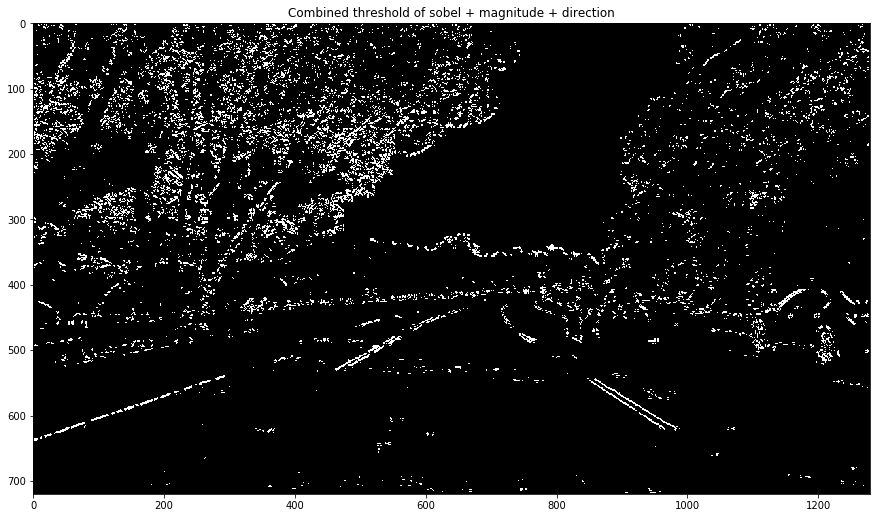

In [69]:
# TEST - combined thresholds

plt.figure(figsize=(15,10))
plt.title('Combined threshold of sobel + magnitude + direction')  
plt.imshow(comb, cmap = 'gray')

### Color filters and thresholding

In [70]:
def color_thresh(img):
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    return s_binary, l_binary, b_binary, combined_binary

### Color and Gradient thresholding combined

In [71]:
def combine_color_gradients(image):

    sxbinary = combined_thresh(image)
    s_binary, l_binary, b_binary, combined_color_binary = color_thresh(image)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(l_binary == 1) | (b_binary == 1) | ((sxbinary == 1) & (s_binary == 1))] = 1
    combined_binary[ (combined_color_binary == 1) | (sxbinary == 1) ] = 1
    
    return combined_binary

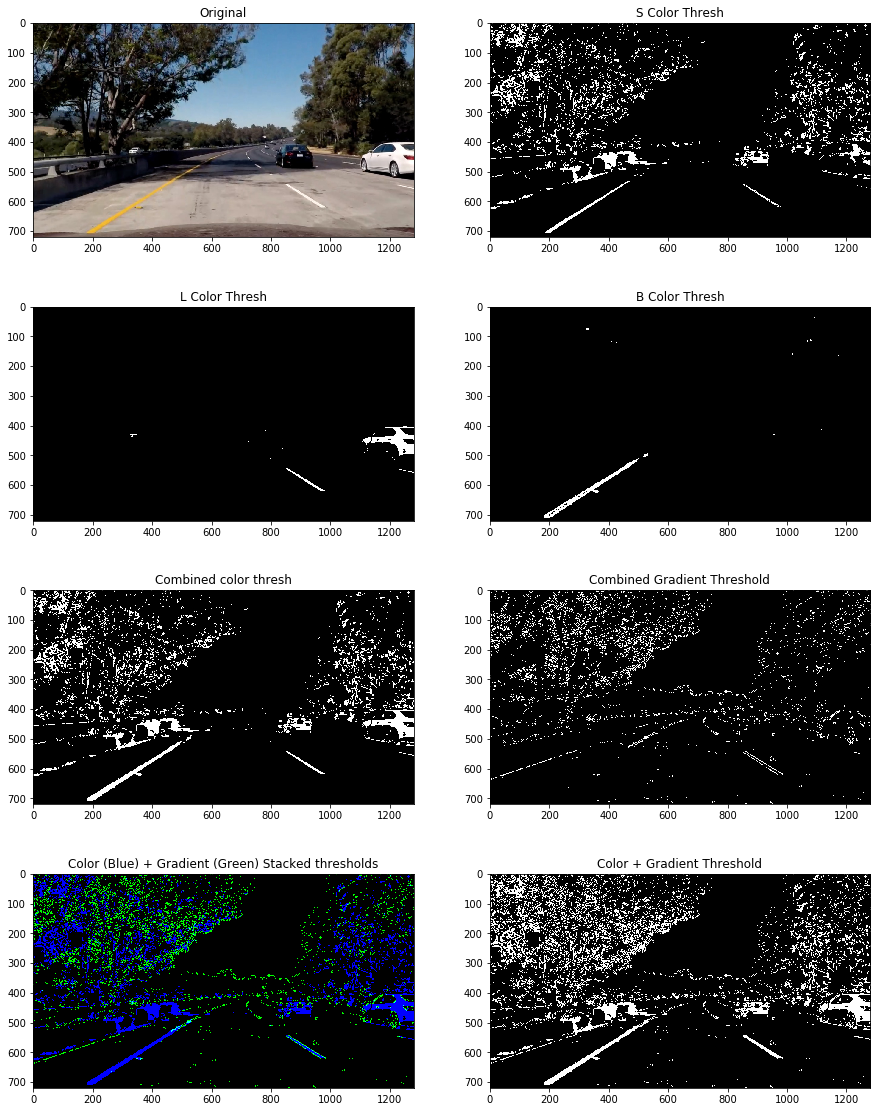

In [72]:
# TEST

sxbinary = combined_thresh(test_undistorted)
s_binary, l_binary, b_binary, combined_color_binary = color_thresh(test_undistorted)
combined_color_gradient = combine_color_gradients(test_undistorted)

# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, combined_color_binary)) * 255

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(15,20))
ax1.set_title('Original')
ax1.imshow(test_undistorted)
ax2.set_title('S Color Thresh')  
ax2.imshow(s_binary, cmap = 'gray')
ax3.set_title('L Color Thresh')  
ax3.imshow(l_binary, cmap = 'gray')
ax4.set_title('B Color Thresh')  
ax4.imshow(b_binary, cmap = 'gray')
ax5.set_title('Combined color thresh')  
ax5.imshow(combined_color_binary, cmap = 'gray')
ax6.set_title('Combined Gradient Threshold')  
ax6.imshow(sxbinary, cmap = 'gray')
ax7.set_title('Color (Blue) + Gradient (Green) Stacked thresholds')
ax7.imshow(color_binary)
ax8.set_title('Color + Gradient Threshold')  
ax8.imshow(combined_color_gradient, cmap = 'gray')

### Warping - Perpesctive Transform and Birds Eye View

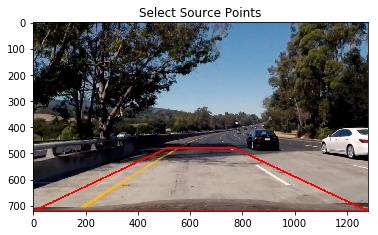

In [73]:
# Selecting and visualizing source points


# src_points = np.int32([                    
#                 [0.117 * x, y],
#                 [(0.5 * x) - (x*0.077), (2/3)*y],
#                 [(0.5 * x) + (x*0.077), (2/3)*y],
#                 [x - (0.117 * x), y]
#                 ])


x = test_undistorted.shape[1]
y = test_undistorted.shape[0]
image_size = test_undistorted.shape

horizon = np.uint(2*image_size[0]/3)
center_lane = np.uint(image_size[1]/2)
offset = 0.2

x_left_bottom = center_lane - center_lane
x_right_bottom = 2*center_lane
x_right_upper = center_lane + offset*center_lane
x_left_upper = center_lane - offset*center_lane


src_points = np.int32([
                       [x_left_bottom, y],
                       [x_right_bottom, y],
                       [x_right_upper, horizon],
                       [x_left_upper, horizon]
                      ])

# dst_points = np.float32([
#                         [0,y],
#                         [x,y],
#                         [x,0],
#                         [0,0]
#                         ])

#             |
#             |
#             |
#             |
#             |
#             v

#   Source	   Destination
# 720, 0	    720, 0
# 1280, 720	    720, 1200
# 768, 480	     0, 1200
# 512, 480	     0, 0

draw_poly = cv2.polylines(test_undistorted,[src_points],True,(255,0,0), 5)
plt.title('Select Source Points')  
plt.imshow(draw_poly)

# Restore image
test_undistorted = mpimg.imread('test_images/test5.jpg')


In [74]:
def warp(image):

#     src_points = np.float32([                    
#                     [0.117 * x, y],
#                     [(0.5 * x) - (x*0.077), (2/3)*y],
#                     [(0.5 * x) + (x*0.077), (2/3)*y],
#                     [x - (0.117 * x), y]
#                     ])
    
        
#     dst_points = np.float32([
#                     [0.25 * x, y],
#                     [0.25 * x, 0],
#                     [x - (0.25 * x), 0],
#                     [x - (0.25 * x), y]
#                     ])
    
    x = image.shape[1]
    y = image.shape[0]
    image_size = image.shape

    horizon = np.uint(2*image_size[0]/3)
    center_lane = np.uint(image_size[1]/2)
    offset = 0.2

    x_left_bottom = center_lane - center_lane
    x_right_bottom = 2*center_lane
    x_right_upper = center_lane + offset*center_lane
    x_left_upper = center_lane - offset*center_lane


    src_points = np.float32([
                           [x_left_bottom, y],
                           [x_right_bottom, y],
                           [x_right_upper, horizon],
                           [x_left_upper, horizon]
                          ])

    dst_points = np.float32([
                            [0.15*x,y],
                            [x - 0.15*x,y],
                            [x - 0.15*x,0],
                            [0.15*x,0]
                            ])

    #             |
    #             |
    #             |
    #             |
    #             |
    #             v

    #   Source	   Destination
    # 720, 0	    192, 720
    # 1280, 720	    1088, 720
    # 768, 480	     1088, 0
    # 512, 480	     192, 0

    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped


# Inverse warp
def inv_warp(image):
    
    x = image.shape[1]
    y = image.shape[0]
    image_size = image.shape

    horizon = np.uint(2*image_size[0]/3)
    center_lane = np.uint(image_size[1]/2)
    offset = 0.2

    x_left_bottom = center_lane - center_lane
    x_right_bottom = 2*center_lane
    x_right_upper = center_lane + offset*center_lane
    x_left_upper = center_lane - offset*center_lane


    src_points = np.float32([
                           [x_left_bottom, y],
                           [x_right_bottom, y],
                           [x_right_upper, horizon],
                           [x_left_upper, horizon]
                          ])

    dst_points = np.float32([
                            [0.15*x,y],
                            [x - 0.15*x,y],
                            [x - 0.15*x,0],
                            [0.15*x,0]
                            ])


    M = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

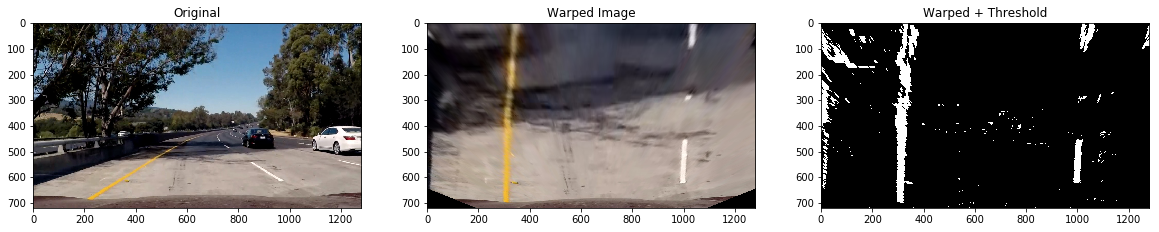

In [75]:
# TEST

comb = combine_color_gradients(test_undistorted)
warp_img = warp(test_undistorted)
thresh_warp_img = warp(comb)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,17))
plt.title('Warping - Perpesctive Transform and Birds Eye View')  
ax1.set_title('Original')
ax1.imshow(test_undistorted)
ax2.set_title('Warped Image')  
ax2.imshow(warp_img, cmap = 'gray')
ax3.set_title('Warped + Threshold')  
ax3.imshow(thresh_warp_img, cmap = 'gray')

<function matplotlib.pyplot.show>

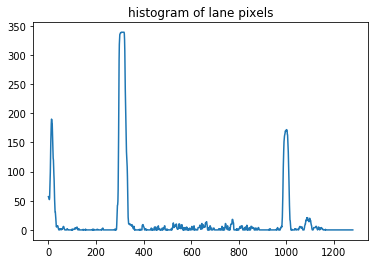

In [76]:
# Take a histogram of the bottom half of the image
histogram = np.sum(thresh_warp_img[thresh_warp_img.shape[0]//2:,:], axis=0)

plt.plot(histogram)
plt.title("histogram of lane pixels")
plt.show

### Various processing functions

In [77]:
# Obtain the coordinates of the pixels on the lane

def filter_pixels(img, x_center, width=100):
    rectangles = []
    x_pixels = []
    y_pixels = []
    
    
    sections = img.shape[0]/len(x_center)
    
    for index_y in range(img.shape[0]-1,-1,-1):
        center = x_center[(len(x_center)-1)-math.floor(index_y/sections)]
        for index_x in range(img.shape[1]):
            
            if abs(index_x - center) < int(width/2):
                pixel = img[index_y][index_x]
                if pixel:
                    x_pixels.append(index_x)
                    y_pixels.append(index_y)
    

    return x_pixels, y_pixels

In [78]:
#Find the center of the detected lanes

def find_two_peaks_image(img, side='left'):

    out = np.zeros(img.shape[1])
    histogram = np.sum(img, axis=0, out = out)
    
    first_half = int(len(histogram)/2)
    left = histogram[:first_half]
    
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
            left_second_peak = left_first_peak+counter
            
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
            right_second_peak = right_first_peak+counter
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [79]:
def find_peak(img):

    out = np.zeros(img.shape[1])
    histogram = np.sum(img, axis=0, out = out)

    first_peak = np.argmax(histogram)
    value_peak = histogram[first_peak]

    dummy_histogram_array = histogram[first_peak:]

    counter = 0
    
    for white_count in dummy_histogram_array:
        if white_count != 0:
            counter = counter +1

        else:
            break
            
    second_peak = first_peak+counter
    
    peak = first_peak + (second_peak - first_peak)/2
     
    return peak

In [80]:
#     Iterate over the detected line to obtain the x coordinates of the center of
#     lines, it start at the center obtain before

def sliding_window(image, center, delta):
   
    center = int(center)

    width = image.shape[1]
    window_width = 100

    height = image.shape[0]

    
    sections = int(height / delta)
    x_centers = [center]
    y_centers = []
    y_initials = []
    y_start = height

    for index in range(1,sections+1):
        y_final = height - index*delta
        y_initials.append(y_start)
        
        left_limit = center-100
        right_limit = center+ 100
        
        
        image_test = image[y_final:y_start,left_limit: right_limit]

        center = find_peak(image_test) + left_limit
        center = int(center)

        x_centers.append(center)

        y_start = y_final
        
    
    return x_centers

In [81]:
#     Obtain the coordinates of the pixels of a line starting at the same
#     center of the last detected line, avoids to do the sliding window.

def guided_search(img, warped, recent_xfitted):
    
    OFFSET = 30
    y_pixels = []
    x_pixels = []
    all_xlast_fitted = []
    all_ylast_fitted = []
    y_list = []
    x0_list = []

    for index_y in range(img.shape[0]-1,-1,-1):

        x_last_fit = int(recent_xfitted[int(index_y/7.2)])

            
        if x_last_fit - OFFSET < 0:
            x0 = 0
        else:
            x0 = x_last_fit - OFFSET
        
        if x_last_fit + OFFSET >= img.shape[1]:
            x1 = img.shape[1]
        else:
            x1 = x_last_fit + OFFSET

        for x_index in range(x0,x1):
            if warped[index_y][x_index] == 1:                   
                x_pixels.append(x_index)
                y_pixels.append(index_y)

    
    return x_pixels, y_pixels

 ### Lane Lines Class for storing characteristics

In [82]:
#Class for lane detection

''' NOTE :

 xm_per_pixel = 3.675 / 700 (3.675 actual width of lane, 700 px on warped image)
 ym_per_pixel = 3.048 / 190 (3 m actual length of dashed line, 190 px length on warped image)
 
'''

class LaneLines():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Average radius of curvature of the left and right lines 
        self.avg_radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #slope for detected line
        self.slope = None
        #position car
        self.position = 0 
        #Offset of the car from center
        self.offset = 0 


    
     # When a new line is detected, all the attributes need to be updated
    def push_line(self, yvals, allx, ally):       
        self.detected = True
        self.allx = allx
        self.ally = ally
        
        y_eval = np.max(yvals)
        
        side_fit = LaneLines.calculate_polyfit(ally, allx)        
        self.current_fit = side_fit    
        
        xvals = LaneLines.calculate_xvalues(yvals, side_fit)
        
        self.calculate_average_xvalues(np.array(xvals))
        
        
        side_curverad = LaneLines.calculate_curvature_pixels(side_fit, y_eval)
        self.radius_of_curvature = side_curverad
        
        self.slope = LaneLines.calculate_slope(self.allx[0], self.allx[-1], self.ally[0],self.ally[-1])
        
        
        
#         ym_per_pix: meters per pixel in y dimension
#         xm_per_pix: meteres per pixel in x dimension
    def get_curvature_meters(self, yvals, y_eval, ym_per_pix = 3.048/190, xm_per_pix = 3.675/700 ):
        
        side_fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        side_curverad = ((1 + (2*side_fit_cr[0]*y_eval*ym_per_pix  + side_fit_cr[1])**2)**1.5) \
                            /np.absolute(2*side_fit_cr[0])
            
            
        return side_curverad
    
    
    def calculate_average_xvalues(self, xvals, n=5):
        self.recent_xfitted.append(xvals)
        
        if len(self.recent_xfitted) < n:
            n_last = self.recent_xfitted
        else:
            n_last = self.recent_xfitted[-n:]
            
        self.recent_xfitted = n_last
        self.bestx = np.mean(n_last, axis=0)

    
    def calculate_polyfit(ally, allx):
        coefficients = np.polyfit(ally, allx, 2)
        
        return coefficients
    
    
    def calculate_xvalues(yvals, side_fit):
        xvals = side_fit[0]*yvals**2 + side_fit[1]*yvals + side_fit[2]
        return xvals
    
    
    def calculate_curvature_pixels (side_fit, y_eval, ym_per_pix = 3.048/190):
        curvature_pixels = ((1 + (2*side_fit[0]*y_eval*ym_per_pix  + side_fit[1])**2)**1.5) \
                             /np.absolute(2*side_fit[0])
        
        return curvature_pixels
    
    
    def calculate_slope(x1,x2,y1,y2):
        slope = (y2-y1)/(x2-x1)
        return slope


In [88]:
# Function to draw Lane Lines

def draw_lane(und_image, warped, left_lane, right_lane):

    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    y_eval = np.max(yvals)

    #LEFT LANE
    if not left_lane.detected:

        center1= find_two_peaks_image(warped)

        x_center = sliding_window(warped, center1, 120)

        x_pixels,y_pixels = filter_pixels(warped,x_center)


        new_line_detected_left = LaneLines()

        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))

    else:

        new_line_detected_left = LaneLines()
        x_pixels, y_pixels = guided_search(und_image, warped, left_lane.recent_xfitted[-1])
        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))



    #RIGTH LANE
    if not right_lane.detected:
        center2 = find_two_peaks_image(warped, 'right')

        x2_center = sliding_window(warped, center2, 120)

        x_pixels_r,y_pixels_r = filter_pixels(warped,x2_center)

        new_line_detected_right = LaneLines()

        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))


    else: 

        new_line_detected_right = LaneLines()
        x_pixels_r, y_pixels_r =guided_search(und_image, warped, right_lane.recent_xfitted[-1])
        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))

# ---------------------------------------------------------------------------------------------------------

    if new_line_detected_left.detected and new_line_detected_right.detected:
        check_slope = 1 < abs(new_line_detected_left.slope)
        check_slope = 1 < abs(new_line_detected_right.slope) and check_slope
        check_curve = new_line_detected_left.radius_of_curvature > 1100
        check_curve = new_line_detected_right.radius_of_curvature > 1100 and check_curve

        check_distance = True
        for index in range(len(new_line_detected_left.recent_xfitted[-1])):
            distance =new_line_detected_left.recent_xfitted[-1][index]-new_line_detected_right.recent_xfitted[-1][index]

            if (abs(distance)) < 600:            
                check_distance = False


        if check_slope and check_curve and check_distance:


            left_lane.push_line(yvals, new_line_detected_left.allx,new_line_detected_left.ally)
            left_lane.detected = True

            right_lane.push_line(yvals,new_line_detected_right.allx, new_line_detected_right.ally) 
            right_lane.detected = True


            center = und_image.shape[1]/2
            #Width lane is around 700 px in the image, 3.65 is actual width lane in meters
            xm_per_pix = 3.675/700 

            lanes_middle_distance = abs(right_lane.recent_xfitted[-1][0] + left_lane.recent_xfitted[-1][0])/2

            position_car_pixels = center - lanes_middle_distance 
            position_car_meters = position_car_pixels *xm_per_pix
            left_lane.position = position_car_meters


    else:
        left_lane.detected = False
        right_lane.detected = False



    #Drawing the lines back down onto the road
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_color = np.dstack((warp_zero, warp_zero, warp_zero))
    
    avg_radius_of_curvature = ''
    offset = ''

    # Recast the x and y points into usable format for cv2.fillPoly()
    if left_lane.bestx is not None and right_lane.bestx is not None:
        pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, yvals])))])
        pts = np.hstack((pts_left, pts_right))

        #Calculate avg radious of curvature and vehicle offet
        avg_radius_of_curvature =     ( np.round(left_lane.get_curvature_meters(yvals, y_eval)) + 
                                        np.round(right_lane.get_curvature_meters(yvals, y_eval))
                                        )/2
        if avg_radius_of_curvature > 10000:
            avg_radius_of_curvature = 'inf'
        else:
            avg_radius_of_curvature = str(avg_radius_of_curvature)
            
        offset  = str(round(left_lane.position,3))


    # Draw the lane onto the warped blank image
    
        cv2.polylines(warp_color, np.int_([pts_left]), isClosed=False, color=(0,0,255), thickness = 20)
        cv2.polylines(warp_color, np.int_([pts_right]), isClosed=False, color=(255,0,0), thickness = 20) 
#        plt.imshow(warp_color)
        cv2.fillPoly(warp_color, np.int_([pts]), (255,255, 0))

    img_unwrapped = inv_warp(warp_color)

    # Draw final concatenated result
    result = cv2.addWeighted(und_image, 1, img_unwrapped, 0.3, 0)

    cv2.putText(result, 'Radius of Curvature = ' + avg_radius_of_curvature + ' m', (40,70), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,0), 2)
    cv2.putText(result, 'Distance from center = ' + offset[0:5] + ' m', (40,140), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,0), 2)


    return result


In [89]:
left_lane = LaneLines()
right_lane = LaneLines()

In [90]:
def process_image(image):
    undistorted = undistort_img(image)
    filtered_binary = combine_color_gradients(undistorted)
    binary_warped = warp(filtered_binary)
#     global left_lane
#     global right_lane
    final_image = draw_lane(image, binary_warped, left_lane, right_lane)
    return final_image

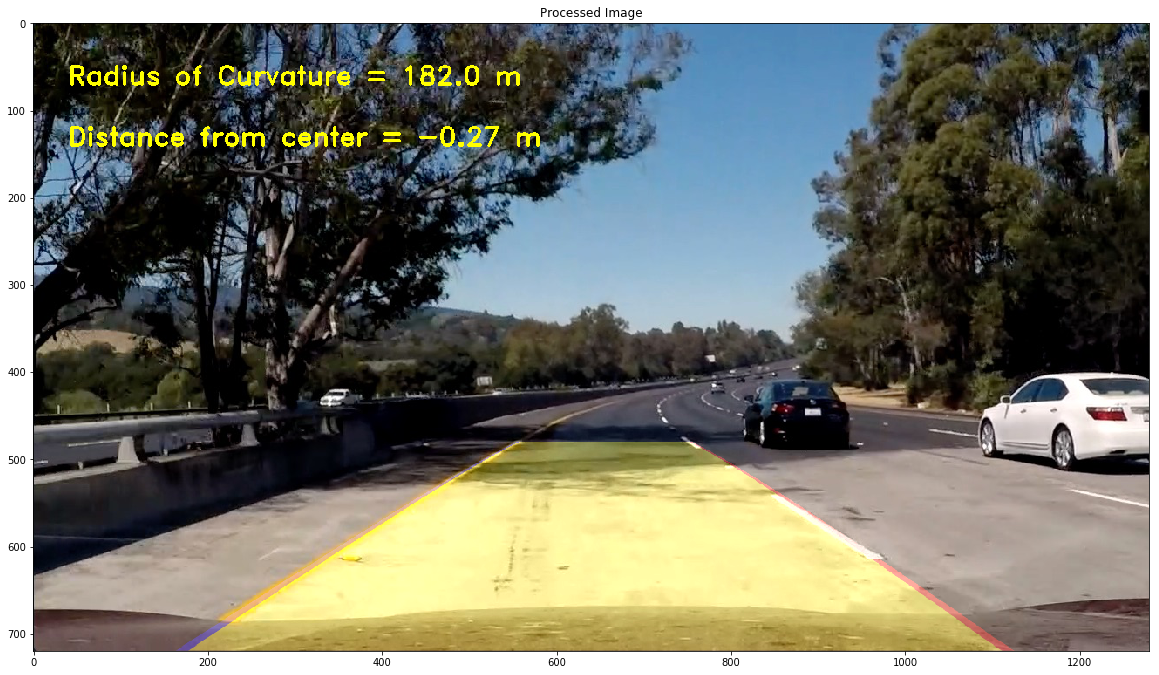

In [91]:
# TEST1

res = process_image(test_undistorted)
plt.figure(figsize=(20,20))
plt.title('Processed Image')  
plt.imshow(res, cmap = 'gray')

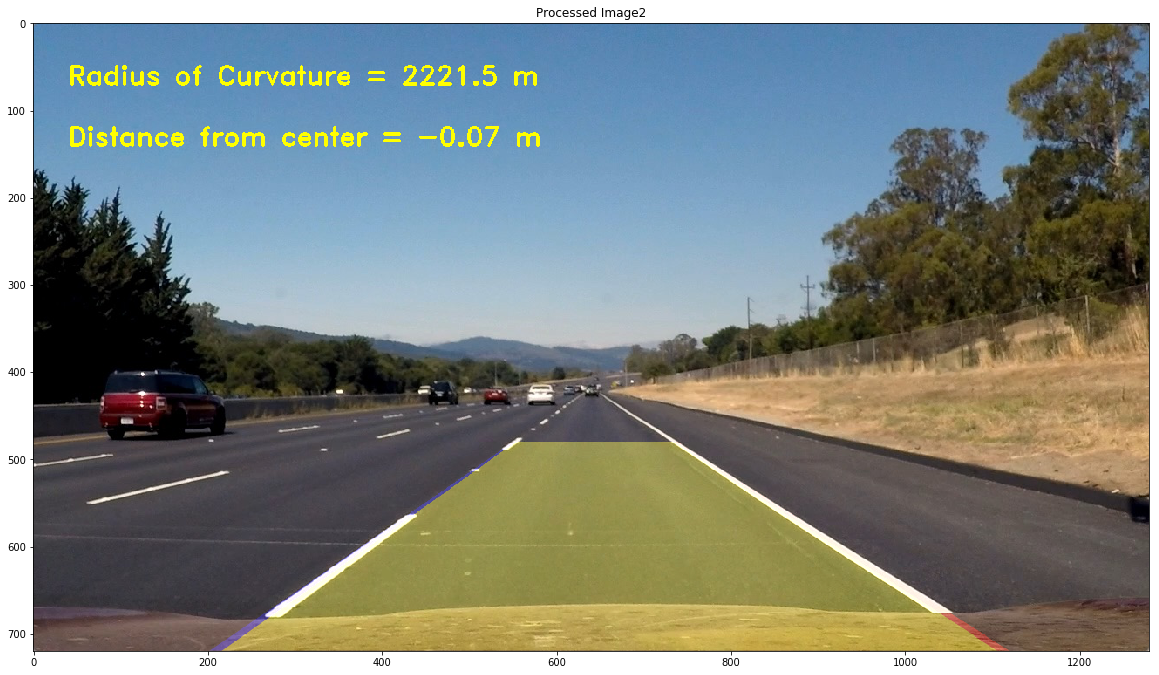

In [92]:
# TEST2


del(left_lane)
del(right_lane)
    
left_lane = LaneLines()
right_lane = LaneLines()

img2 = mpimg.imread('test_images/straight_lines2.jpg')

res2 = process_image(img2)
plt.figure(figsize=(20,20))
plt.title('Processed Image2')  
plt.imshow(res2, cmap = 'gray')

### Testing on videos

In [93]:
white_output = 'output_videos/project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|█████████▉| 1260/1261 [07:21<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 



In [94]:
del(left_lane)
del(right_lane)

left_lane = LaneLines()
right_lane = LaneLines()

white_output = 'output_videos/challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_out.mp4
[MoviePy] Writing video output_videos/challenge_video_out.mp4


 26%|██▋       | 128/485 [01:06<04:01,  1.48it/s]

ValueError: attempt to get argmax of an empty sequence

In [38]:
del(left_lane)
del(right_lane)

left_lane = LaneLines()
right_lane = LaneLines()

white_output = 'output_videos/harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_out.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_out.mp4




  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<14:20,  1.39it/s]

  0%|          | 2/1200 [00:01<14:02,  1.42it/s]

  0%|          | 3/1200 [00:02<13:51,  1.44it/s]

  0%|          | 4/1200 [00:02<13:44,  1.45it/s]

  0%|          | 5/1200 [00:03<13:50,  1.44it/s]

  0%|          | 6/1200 [00:03<12:05,  1.65it/s]

  1%|          | 7/1200 [00:04<10:35,  1.88it/s]

  1%|          | 8/1200 [00:04<09:33,  2.08it/s]

  1%|          | 9/1200 [00:04<08:56,  2.22it/s]

  1%|          | 10/1200 [00:05<08:27,  2.35it/s]

  1%|          | 11/1200 [00:05<07:59,  2.48it/s]

  1%|          | 12/1200 [00:06<07:42,  2.57it/s]

  1%|          | 13/1200 [00:06<07:47,  2.54it/s]

  1%|          | 14/1200 [00:06<07:33,  2.61it/s]

  1%|▏         | 15/1200 [00:07<07:25,  2.66it/s]

  1%|▏         | 16/1200 [00:07<07:24,  2.66it/s]

  1%|▏         | 17/1200 [00:07<07:33,  2.61it/s]

  2%|▏         | 18/1200 [00:08<07:20,  2.68it/s]

  2%|▏         | 19/1200 [00:08<07:13,  2.73it/

 24%|██▎       | 284/1200 [01:37<05:22,  2.84it/s]

 24%|██▍       | 285/1200 [01:38<05:24,  2.82it/s]

 24%|██▍       | 286/1200 [01:38<05:25,  2.81it/s]

 24%|██▍       | 287/1200 [01:39<05:39,  2.69it/s]

 24%|██▍       | 288/1200 [01:39<05:38,  2.70it/s]

 24%|██▍       | 289/1200 [01:39<05:47,  2.62it/s]

 24%|██▍       | 290/1200 [01:40<05:54,  2.57it/s]

 24%|██▍       | 291/1200 [01:40<05:42,  2.66it/s]

 24%|██▍       | 292/1200 [01:40<05:46,  2.62it/s]

 24%|██▍       | 293/1200 [01:41<05:41,  2.66it/s]

 24%|██▍       | 294/1200 [01:41<05:33,  2.72it/s]

 25%|██▍       | 295/1200 [01:42<05:26,  2.77it/s]

 25%|██▍       | 296/1200 [01:42<05:22,  2.80it/s]

 25%|██▍       | 297/1200 [01:42<05:21,  2.81it/s]

 25%|██▍       | 298/1200 [01:43<05:18,  2.83it/s]

 25%|██▍       | 299/1200 [01:43<05:30,  2.73it/s]

 25%|██▌       | 300/1200 [01:43<05:31,  2.71it/s]

 25%|██▌       | 301/1200 [01:44<05:27,  2.74it/s]

 25%|██▌       | 302/1200 [01:44<05:22,  2.79it/s]

 25%|██▌    

 47%|████▋     | 566/1200 [03:15<02:56,  3.59it/s]

 47%|████▋     | 567/1200 [03:15<02:57,  3.57it/s]

 47%|████▋     | 568/1200 [03:15<02:55,  3.60it/s]

 47%|████▋     | 569/1200 [03:15<02:53,  3.63it/s]

 48%|████▊     | 570/1200 [03:16<02:55,  3.59it/s]

 48%|████▊     | 571/1200 [03:16<02:55,  3.58it/s]

 48%|████▊     | 572/1200 [03:16<02:55,  3.57it/s]

 48%|████▊     | 573/1200 [03:17<02:54,  3.59it/s]

 48%|████▊     | 574/1200 [03:17<02:53,  3.60it/s]

 48%|████▊     | 575/1200 [03:17<02:54,  3.59it/s]

 48%|████▊     | 576/1200 [03:17<02:54,  3.58it/s]

 48%|████▊     | 577/1200 [03:18<02:56,  3.54it/s]

 48%|████▊     | 578/1200 [03:18<02:56,  3.53it/s]

 48%|████▊     | 579/1200 [03:18<02:55,  3.53it/s]

 48%|████▊     | 580/1200 [03:19<02:56,  3.52it/s]

 48%|████▊     | 581/1200 [03:19<02:55,  3.53it/s]

 48%|████▊     | 582/1200 [03:19<02:55,  3.52it/s]

 49%|████▊     | 583/1200 [03:19<02:55,  3.52it/s]

 49%|████▊     | 584/1200 [03:20<02:54,  3.52it/s]

 49%|████▉  

 71%|███████   | 848/1200 [04:52<02:06,  2.79it/s]

 71%|███████   | 849/1200 [04:53<02:07,  2.76it/s]

 71%|███████   | 850/1200 [04:53<02:11,  2.67it/s]

 71%|███████   | 851/1200 [04:53<02:07,  2.74it/s]

 71%|███████   | 852/1200 [04:54<02:14,  2.59it/s]

 71%|███████   | 853/1200 [04:54<02:26,  2.38it/s]

 71%|███████   | 854/1200 [04:55<02:23,  2.42it/s]

 71%|███████▏  | 855/1200 [04:55<02:16,  2.54it/s]

 71%|███████▏  | 856/1200 [04:55<02:15,  2.54it/s]

 71%|███████▏  | 857/1200 [04:56<02:14,  2.54it/s]

 72%|███████▏  | 858/1200 [04:56<02:11,  2.59it/s]

 72%|███████▏  | 859/1200 [04:57<02:08,  2.66it/s]

 72%|███████▏  | 860/1200 [04:57<02:05,  2.72it/s]

 72%|███████▏  | 861/1200 [04:57<02:02,  2.77it/s]

 72%|███████▏  | 862/1200 [04:58<02:01,  2.78it/s]

 72%|███████▏  | 863/1200 [04:58<01:59,  2.82it/s]

 72%|███████▏  | 864/1200 [04:58<01:59,  2.81it/s]

 72%|███████▏  | 865/1200 [04:59<01:58,  2.83it/s]

 72%|███████▏  | 866/1200 [04:59<01:57,  2.85it/s]

 72%|███████

 94%|█████████▍| 1128/1200 [06:16<00:18,  3.80it/s]

 94%|█████████▍| 1129/1200 [06:16<00:18,  3.82it/s]

 94%|█████████▍| 1130/1200 [06:16<00:18,  3.80it/s]

 94%|█████████▍| 1131/1200 [06:17<00:18,  3.81it/s]

 94%|█████████▍| 1132/1200 [06:17<00:17,  3.83it/s]

 94%|█████████▍| 1133/1200 [06:17<00:17,  3.81it/s]

 94%|█████████▍| 1134/1200 [06:18<00:17,  3.80it/s]

 95%|█████████▍| 1135/1200 [06:18<00:17,  3.80it/s]

 95%|█████████▍| 1136/1200 [06:18<00:16,  3.80it/s]

 95%|█████████▍| 1137/1200 [06:18<00:16,  3.80it/s]

 95%|█████████▍| 1138/1200 [06:19<00:16,  3.80it/s]

 95%|█████████▍| 1139/1200 [06:19<00:16,  3.79it/s]

 95%|█████████▌| 1140/1200 [06:19<00:15,  3.80it/s]

 95%|█████████▌| 1141/1200 [06:19<00:15,  3.82it/s]

 95%|█████████▌| 1142/1200 [06:20<00:15,  3.73it/s]

 95%|█████████▌| 1143/1200 [06:20<00:15,  3.74it/s]

 95%|█████████▌| 1144/1200 [06:20<00:15,  3.71it/s]

 95%|█████████▌| 1145/1200 [06:20<00:14,  3.73it/s]

 96%|█████████▌| 1146/1200 [06:21<00:14,  3.76

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_out.mp4 

CPU times: user 7min 18s, sys: 2.73 s, total: 7min 21s
Wall time: 6min 37s
